<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

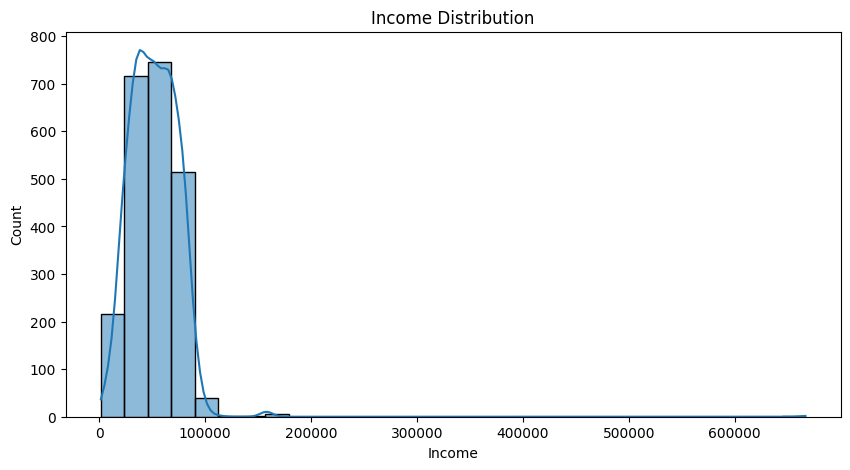

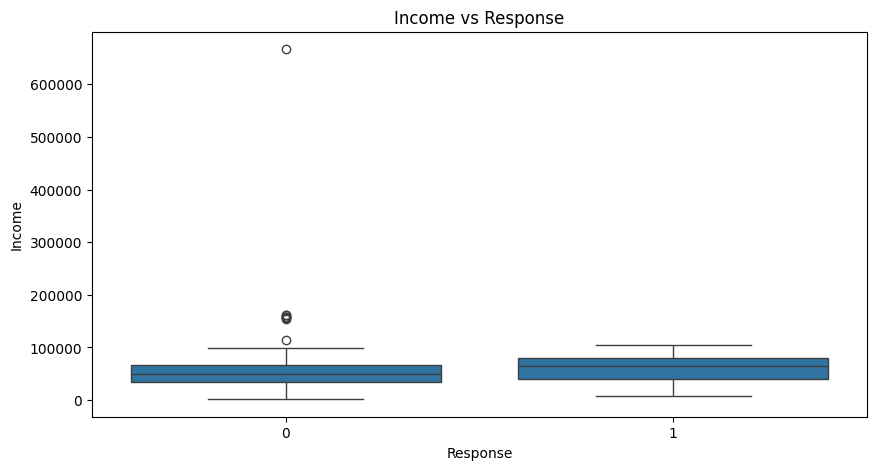

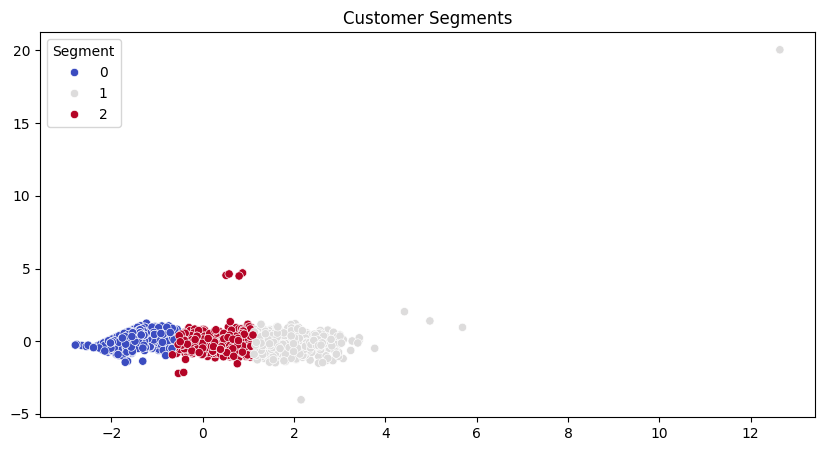

Model Accuracy: 0.859375
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       376
           1       0.70      0.22      0.34        72

    accuracy                           0.86       448
   macro avg       0.78      0.60      0.63       448
weighted avg       0.84      0.86      0.83       448

Segment Insights:
                Income  Total_Spending
Segment                              
0        33611.558402       84.660861
1        75103.215134     1372.765579
2        56929.859322      591.720339


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

# Load Data
df = pd.read_csv("marketing_data.csv")

# Clean Column Names
df.columns = df.columns.str.strip()

# Display basic info
print(df.info())
print(df.describe())

# Handling Missing Values
df['Income'] = df['Income'].str.replace(r'[^\d.]', '', regex=True).astype(float)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Feature Engineering: Creating new features
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Total_Purchases'] = df[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Encoding Categorical Variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_cols = df.select_dtypes(include=['object']).columns
encoded_cols = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

# Exploratory Data Analysis
plt.figure(figsize=(10,5))
sns.histplot(df['Income'], bins=30, kde=True)
plt.title("Income Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df['Response'], y=df['Income'])
plt.title("Income vs Response")
plt.show()

# Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Income', 'Total_Spending', 'Total_Purchases']])

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Customer Segmentation using K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment'] = kmeans.fit_predict(pca_data)

# Visualizing Clusters
plt.figure(figsize=(10,5))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['Segment'], palette='coolwarm')
plt.title("Customer Segments")
plt.show()

# Predictive Modeling using RandomForest
X = df.drop(columns=['Response'])
y = df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Marketing Strategy Recommendations
segment_summary = df.groupby('Segment')[['Income', 'Total_Spending']].mean()
print("Segment Insights:\n", segment_summary)
